# Project 5: Capstone Project
### Learning to Trade Using Q-Learning
<sub>Uirá Caiado. Aug 10, 2016<sub>


#### Abstract

*In this project, I will present an adaptive learning model to trade a single stock under the reinforcement learning framework. This area of machine learning consists in training an agent by reward and punishment without needing to specify the expected action. The agent learns from its experience and develops a strategy that maximizes its profits. The simulation results show initial success in bringing learning techniques to build algorithmic trading strategies.

## 1. Introduction

In this section, I will provide a high-level overview of the project, define the problem addressed and the metric used to measure the performance of the model created.

### 1.1. Project Overview
```
Udacity:

In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?
- Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?
```
Nowadays, algo trading represents almost half of all cash equity trading in western Europe. In advanced markets, it already [accounts](http://en.resenhadabolsa.com.br/portfolio-category/the-distributionintermediation-industry-in-brazil-challenges-and-trends/) for over 40%-50% of total volume. In Brazil its market share is not as large – currently about 10% – but is expected to rise in the years ahead as markets and players go digital.

As automated strategies are becoming increasingly popular, building an intelligent system that can trade many times a day and adapts itself to the market conditions and still consistently makes money is a subject of keen interest of any market participant.

Given that it is hard to produce such strategy, in this project I will try to build an algorithm that just does better than a random agent, but learns by itself how to trade. To do so, I will feed my agent with four days of information about every trade and change in the [top of the order book](https://goo.gl/k1dDYZ) in the [PETR4](https://pt.wikipedia.org/wiki/Petrobras) - one of the most liquidity assets in Brazilian Stock Market - in a Reinforcement Learning Framework. Later on, I will test what it has learned in a newest dataset.

The dataset used in this project is also known as [level I order book data](https://www.thebalance.com/order-book-level-2-market-data-and-depth-of-market-1031118) and includes all trades and changes in the prices and total quantities at best Bid (those who wants to buy the stock) and Offer side (those who intends to sell the stock).


### 1.2. Problem Statement
```
Udacity:

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?
- Have you thoroughly discussed how you will attempt to solve the problem?
- Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?
```
[Algo trading](http://goo.gl/b9jAqE) strategies usually are programs that follow a predefined set of instructions to place its orders. The primary challenge to this approach is building these rules in a way that it can consistently generate profit without being too sensitive to market conditions. 

Thus, the goal of this project is to develop an adaptative learning model that can learn by itself those rules and trade a particular asset using reinforcement learning framework under an environment that replays historical high-frequency data.

As \cite{chan2001electronic} describe, reinforcement learning can be considered as a model-free approximation of dynamic programming. The knowledge of the underlying processes is not assumed but learned from experience.

The agent can access some information about the environment state as the order flow imbalance, the sizes of the best bid and offer and so on. At each time step $t$, It should generate some valid action, as buy stocks or insert a limit order at the Ask side. All inputs and actions will be detailed in the next sections.

The agent also should receive a reward or a penalty at each time step if it is already carrying a position from previous rounds or if it has made a trade (the cost of the operations are computed as a penalty).

Based on the rewards and penalties it gets, the agent should learn an optimal policy for trade this particular stock, maximizing the profit it receives from its actions and resulting positions.





### 1.3. Metrics
```
Udacity:

In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?
- Have you provided reasonable justification for the metrics chosen based on the problem and solution?
```

In 1988, the Wall Street Journal created a [Dartboard Contest](http://www.automaticfinances.com/monkey-stock-picking/), where Journal staffers threw darts at a stock table to select their assets, while investment experts picked their own stocks. After six months, they compared the results of the two methods. After adjusting the results to risk level, they found out that the pros barely have beaten the random pickers.

Given that, the metric used to measure the performance of the learner will be the amount of money made by a random agent. So, my goal will be to outperform this agent, that should just produce some random action from a set of allowed action at each time $t$. In the next section, I will detail the behavior of this agent.

## 2. Analysis

In this section, I will explore the data set that will be used in the simulation, define and justify the inputs employed in the state representation of the algorithm, explain the reinforcement learning techniques used and provide a benchmark.

### 2.1. Data Exploration
```
Udacity:

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?
- If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?
- If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?
- Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)
```
The dataset used is composed by level I order book data from PETR4, a stock traded at BMFBovespa Stock Exchange. Includes 19 trading sessions from 07/25/2016 to 09/26/2016. I will use one day to create the scalers of the features used, that I shall explain. Then, I will use four days to train and test the model, and after each training session, I will validate the policy found in an unseen dataset from the subsequent day. The data was collected from Bloomberg. *Let's start by looking at the size of these files:*

In [85]:
import zipfile
s_fname = "data/data_0725_0926.zip"
archive = zipfile.ZipFile(s_fname, 'r')
def foo():
    f_total = 0.
    f_tot_rows = 0.
    for i, x in enumerate(archive.infolist()):
        f_total += x.file_size/ 1024.**2
        for num_rows, row in enumerate(archive.open(x)):
            f_tot_rows += 1
        print "{}:\t{:,.0f} rows\t{:0.2f} MB".format(x.filename, num_rows + 1, x.file_size/ 1024.**2)
    print '=' * 42
    print "TOTAL\t\t{} files\t{:0.2f} MB".format(i+1,f_total)
    print "\t\t{:0,.0f} rows".format(f_tot_rows)

%time foo()

20160725.csv:	110,756 rows	4.42 MB
20160726.csv:	100,109 rows	3.98 MB
20160727.csv:	123,175 rows	4.93 MB
20160728.csv:	109,655 rows	4.37 MB
20160729.csv:	135,111 rows	5.40 MB
20160801.csv:	109,710 rows	4.37 MB
20160802.csv:	108,053 rows	4.30 MB
20160803.csv:	137,039 rows	5.49 MB
20160804.csv:	139,118 rows	5.56 MB
20160805.csv:	112,852 rows	4.51 MB
20160808.csv:	89,730 rows	3.55 MB
20160809.csv:	83,826 rows	3.33 MB
20160810.csv:	105,758 rows	4.21 MB
20160811.csv:	144,728 rows	5.81 MB
20160812.csv:	147,086 rows	5.90 MB
20160815.csv:	108,633 rows	4.33 MB
20160816.csv:	108,795 rows	4.33 MB
20160817.csv:	118,980 rows	4.75 MB
20160818.csv:	84,489 rows	3.36 MB
20160819.csv:	98,329 rows	4.00 MB
20160822.csv:	98,594 rows	4.02 MB
20160823.csv:	90,752 rows	3.69 MB
20160824.csv:	87,930 rows	3.56 MB
20160825.csv:	95,929 rows	3.89 MB
20160826.csv:	152,547 rows	6.24 MB
20160829.csv:	98,630 rows	4.02 MB
20160830.csv:	122,067 rows	4.98 MB
20160831.csv:	155,391 rows	6.37 MB
20160901.csv:	150,122 rows	6.

There are 45 files, each one has 110,000 rows on average, resulting in 5,631,273 rows at total and almost  230 MB of information. Now, let's look at the structure of one of them:

In [28]:
import pandas as pd
l_fnames = archive.infolist()
df = pd.read_csv(archive.open(l_fnames[0]), index_col=0, parse_dates=['Date'])
df.head()

,Date,Type,Price,Size
0,2016-07-25 10:02:00,TRADE,11.98,5800
1,2016-07-25 10:02:00,BID,11.97,6100
2,2016-07-25 10:02:00,ASK,11.98,51800
3,2016-07-25 10:02:00,ASK,11.98,56800
4,2016-07-25 10:02:00,ASK,11.98,56900


Each file is composed of four different fields. The column $Date$ is the timestamp of the row and has a precision of seconds. $Type$ is the kind of information that the row encompasses. The type "TRADE" relates to an actual trade that has happened. "BID" is related to changes in the best Bid level and "ASK," to the best Offer level. $Price$ is the current best bid or ask and $Size$ is the cumulated quantity on that price and side.

All this data will be used to create the environment where my agent will operate. This environment is an order book, where the agent will be able to insert limit orders and execute trades at the best prices. The order book is represented by two binary trees, one for the Bid and other for the Ask side. As can be seen in the table below, the nodes of these trees are sorted by price (price level) in ascending order on the Bid side and descending order on the ask side. At each price level, there are other binary trees sorted by order of arrival. The first order to arrive is the first order filled when coming in a trade.

In [4]:
import qtrader.simulator as simulator
import qtrader.environment as environment
e = environment.Environment()
sim = simulator.Simulator(e)
%time sim.run(n_trials=1)

CPU times: user 13.8 s, sys: 45.4 ms, total: 13.9 s
Wall time: 13.9 s


In [8]:
sim.env.get_order_book()

,qBid,Bid,Ask,qAsk
0,"61,400",12.02,12.03,"13,800"
1,"47,100",12.01,12.04,"78,700"
2,"51,700",12.00,12.05,"20,400"
3,"37,900",11.99,12.06,"23,100"
4,"97,000",11.98,12.07,"27,900"


The environment will answer with the agent's current position and Profit and Loss (PnL) every time the agent executes a trade or has an order filled. The cost of the trade will be accounted as a penalty.

The agent also will be able to sense the state of the environment and include it in its own state representation. So, this intern state will be represented by a set of variables about the current situation os the market and the state of the agent, given by:

- $qOFI$ : integer. The net order flow at the bid and ask in the last 10 seconds
- $book\_ratio$ : float. The Bid size over the Ask size
- $position$: integer. The current position of my agent. The maximum is $100$
- $OrderBid$: boolean. If the agent has order at the bid side
- $OrderAsk$: boolean. If the agent has order at the ask side


```
Udacity:

Exploratory Visualization:

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- Have you visualized a relevant characteristic or feature about the dataset or input data?
- Is the visualization thoroughly analyzed and discussed?
- If a plot is provided, are the axes, title, and datum clearly defined?
```

Regarding the measure of the Order Flow Imbalance (OFI), there are many ways to measure it. \cite{cont2014price} argued the *order flow imbalance* is a measure of supply/demand imbalance and defines it as a sum of individual event contribution $e_n$ over time intervals $\left[ t_{k-1}, \; t_k \right]$, such that:

$$OFI_k = \sum^{N(t_k)}_{n=N(t_{k-1})+1} e_n$$

Where $N(t_k)$ and $N(t_{k-1}) + 1$ are index of the first and last event in the interval. The $e_n$ was defined by the authors as a measure of the contribution of the $n$-th event to the size of the bid and ask queues:

$$e_n = \mathbb{1}_{P_{n}^{B} \geq P_{n-1}^{B}} q^{B}_{n} - \mathbb{1}_{P_{n}^{B} \leq P_{n-1}^{B}}  q^{B}_{n-1} - \mathbb{1}_{P_{n}^{A} \leq P_{n-1}^{A}} q^{A}_{n} + \mathbb{1}_{P_{n}^{A} \geq P_{n-1}^{A}}  q^{A}_{n-1}$$

Where $q^{B}_{n}$ and $q^{A}_{n}$ are linked to the cumulated quantities at the best bid and ask in the time $n$. The subscript $n-1$ is related to the last observation. $\mathbb{1}$ is an [indicator](https://en.wikipedia.org/wiki/Indicator_function) function. In the figure below is ploted the 10-second log-return of PETR4 against the contemporaneous OFI.

In [9]:
import qtrader.eda as eda; reload(eda);
s_fname = "data/petr4_0725_0818_2.zip"
%time eda.test_ofi_indicator(s_fname, f_min_time=20.)

CPU times: user 2.48 s, sys: 16 ms, total: 2.49 s
Wall time: 2.59 s


(-400000, 400000)

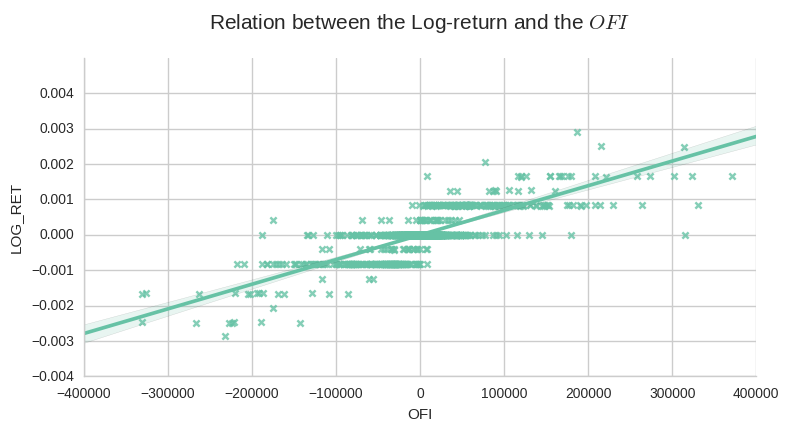

In [20]:
import pandas as pd
df = pd.read_csv('data/ofi_petr.txt', sep='\t')
df.drop('TIME', axis=1, inplace=True)
df.dropna(inplace=True)
ax = sns.lmplot(x="OFI", y="LOG_RET", data=df, markers=["x"], palette="Set2", size=4, aspect=2.)
ax.ax.set_title(u'Relation between the Log-return and the $OFI$\n', fontsize=15);
ax.ax.set_ylim([-0.004, 0.005])
ax.ax.set_xlim([-400000, 400000])

As described by \cite{cont2014price} in a similar test, the figure suggests that order flow imbalance is a stronger driver of high-frequency price changes and this variable will be used to describe the current state of the order book.

### 2.2. Algorithms and Techniques
```
Udacity:

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- Are the algorithms you will use, including any default variables/parameters in the project clearly defined?
- Are the techniques to be used thoroughly discussed and justified?
- Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?
```
Based on \cite{cont2014price}, the algo trading might be conveniently modeled in the framework of reinforcement learning. As suggested by \cite{du1algorithm}, this framework adjusts the parameters of an agent to maximize the expected payoff or reward generated due to its actions. Therefore, the agent learns a policy that tells him the actions it must perform to achieve its best performance. This optimal policy is exactly what we hope to find when we are building an automated trading strategy.

According to \cite{chan2001electronic}, Markov decision processes (MDPs) are the most common model when implementing reinforcement learning.  The MDP model of the environment consists, among other things, of a discrete set of states $S$ and a discrete set of actions taken from $A$. In this project, depending on the position of the learner(long or short), at each time step $t$ it will be allowed to choose an action $a_t$ from different subsets from the action space $A$ , that consists of six possibles actions:

$$a_{t} \in \left (None,\, buy,\, sell,\, best\_bid,\, best\_ask,\, best\_both \right)$$

Where $None$ indicates that the agent shouldn't have any order in the market. $Buy$ and $Sell$ means that the agent should execute a market order to buy or sell $100$ stocks (the size of an order will always be a hundred shares). This kind of action will be allowed based on a [trailing stop](https://goo.gl/SVmVzJ) of 4 cents. $best\_bid$ and $best\_ask$ indicate that the agent should keep order at best price just in the mentioned side and $best\_both$, it should have ordered at best price in both sides.

So, at each discrete time step $t$, the agent senses the current state $s_t$ and choose to take an action $a_t$. The environment responds by providing the agent a reward $r_t=r(s_t, a_t)$ and by producing the succeeding state $s_{t+1}=\delta(s_t, a_t)$. The functions $r$ and $\delta$ only depend on the current state and action (it is [memoryless](https://en.wikipedia.org/wiki/Markov_process)), are part of the environment and are not necessarily known to the agent.

The task of the agent is to learn a policy $\pi$ that maps each state to an action ($\pi: S \rightarrow A$), selecting its next action $a_t$ based solely on the current observed state $s_t$, that is $\pi(s_t)=a_t$. The optimal policy, or control strategy, is the one that produces the greatest possible cumulative reward over time. So, stating that:

$$V^{\pi}(s_t)= r_t + \gamma r_{t+1} + \gamma^2 r_{t+1} + ... = \sum_{i=0}^{\infty} \gamma^{i} r_{t+i}$$

Where $V^{\pi}(s_t)$ is also called the discounted cumulative reward and it represents the cumulative value achieved by following an policy $\pi$ from an initial state $s_t$ and $\gamma \in [0, 1]$ is a constant that determines the relative value of delayed versus immediate rewards. It is one of the

If we set $\gamma=0$, only immediate rewards is considered. As $\gamma \rightarrow 1$, future rewards are given greater emphasis relative to immediate reward. The optimal policy $\pi^{*}$ that will maximizes $V^{\pi}(s_t)$ for all states $s$ can be written as:

$$\pi^{*} = \underset{\pi}{\arg \max} \, V^{\pi} (s)\,\,\,\,\,, \,\, \forall s$$

However, learning $\pi^{*}: S \rightarrow A$ directly is difficult because the available training data does not provide training examples of the form $(s, a)$. Instead, as \cite{Mitchell} explained, the only available information is the sequence of immediate rewards $r(s_i, a_i)$ for $i=1,\, 2,\, 3,\,...$

So, as we are trying to maximize the cumulative rewards $V^{*}(s_t)$ for all states $s$, the agent should prefer $s_1$ over $s_2$ wherever $V^{*}(s_1) > V^{*}(s_2)$. Given that the agent must choose among actions and not states, and it isn't able to perfectly predict the immediate reward and immediate successor for every possible state-action transition, we also must learn $V^{*}$ indirectly.

To solve that, we define a function $Q(s, \, a)$ such that its value is the maximum discounted cumulative reward that can be achieved starting from state $s$ and applying action $a$ as the first action. So, we can write:

$$Q(s, \, a) = r(s, a) + \gamma V^{*}(\delta(s, a))$$

As $\delta(s, a)$ is the state resulting from applying action $a$ to state $s$ (the successor) chosen by following the optimal policy, $V^{*}$ is the cumulative value of the immediate successor state discounted by a factor $\gamma$. Thus,  what we are trying to achieve is

$$\pi^{*}(s) = \underset{a}{\arg \max} Q(s, \, a)$$

It implies that the optimal policy can be obtained even if the agent just uses the current action $a$ and state $s$ and chooses the action that maximizes $Q(s,\, a)$. Also, it is important to notice that the function above implies that the agent can select optimal actions even when it has no knowledge of the functions $r$ and $\delta$.

Lastly, according to \cite{Mitchell}, there are some conditions to ensure that the reinforcement learning converges toward an optimal policy. On a deterministic MDP, the agent must select actions in a way that it visits every possible state-action pair infinitely often. This requirement can be a problem in the environment that the agent will operate.

As the most inputs suggested in the last subsection was defined in an infinite space, in section 3 I will discretize those numbers before use them to train my agent, keeping the state space representation manageable, hopefully. We also will see how \cite{Mitchell} defined a reliable way to estimate training values for $Q$, given only a sequence of immediate rewards $r$.

### 2.3. Benchmark
```
Udacity:

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- Has some result or value been provided that acts as a benchmark for measuring performance?
- Is it clear how this result or value was obtained (whether by data or by hypothesis)?
```

As described before, the performance of my agent will be compared to the performance of a random agent. This random agent should select a random action from a set of valid actions taken from $A$ at each time step $t$.

Just like my learner, the set of action can change over time depending on the open position, that is limited to $100$ stocks at most, on any side. When it reaches its limit, it will be allowed just to perform actions that decrease its position. So, for instance, if it already [long](https://goo.gl/GgXJgR) in $100$ shares, the possible moves would be $\left (None,\, sell,\, best\_ask \right)$. If it is [short](https://goo.gl/XFR7q3), it just can perform $\left (None,\, buy,\, best\_bid\right)$.

The performance will be measured primarily in the money made by the agents (that will be optimized by the learner). First, I will analyze if the learning agent was able to improve its performance on the same dataset after different trials. Later on, I will use the policy learned to simulate the learning agent behavior in a different dataset and then I will compare the final Profit and Loss and volatility of the returns of both agents. All data analyzed will be obtained by simulation.

## 3. Methodology

In this section, I will discretize the input space and implement an agent to learn the Q function.

### 3.1 Data Preprocessing
```
Udacity:

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?
- Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?
- If no preprocessing is needed, has it been made clear why?
```

As mentioned before, I will implement a Markov decision processes (MDP) that requires, among other things, of a discrete set of states $S$. Apart from the input variables $position$, $OrderBid$, $OrderAsk$, the other variables are defined in an infinite domain. I am going to discretize those inputs, so my learning agent can use them in the representation of their intern state. In the Figure bellow, we can see the distribution of those variables. The data was produced using the first day of the dataset.

In [5]:
import pandas as pd
df = pd.read_csv('data/ofi_petr.txt', sep='\t')
df.drop(['TIME', 'DELTA_MID'], axis=1, inplace=True)
df.dropna(inplace=True)

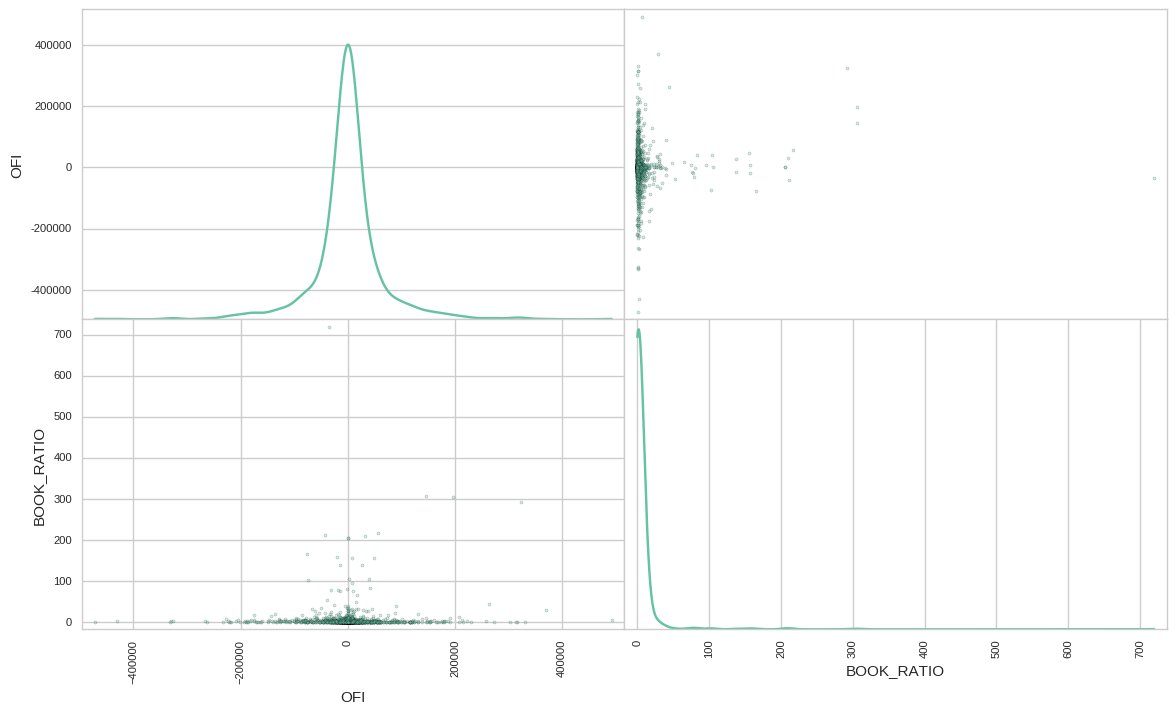

In [6]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(df.ix[:, ['OFI', 'BOOK_RATIO']],
                  alpha = 0.3, figsize = (14,8), diagonal = 'kde');

The scale of the variables is very different, and, in the case of the $BOOK\_RATIO$, it presents a logarithmic distribution. I will apply a logarithm transformation on this variable and rescale both to lie between a given minimum and maximum value of each feature using the function [MinMaxScaler](http://scikit-learn.org/stable/modules/preprocessing.html) from scikit-learn. The result of the transformation can be seen in the figure below.

In [7]:
import sklearn.preprocessing as preprocessing
import numpy as np

In [8]:
scaler_ofi = preprocessing.MinMaxScaler().fit(pd.DataFrame(df.OFI))
scaler_bookratio = preprocessing.MinMaxScaler().fit(pd.DataFrame(np.log(df.BOOK_RATIO)))
d_transformed = {}
d_transformed['OFI'] = scaler_ofi.transform(pd.DataFrame(df.OFI)).T[0]
d_transformed['BOOK_RATIO'] = scaler_bookratio.transform(pd.DataFrame(np.log(df.BOOK_RATIO))).T[0]

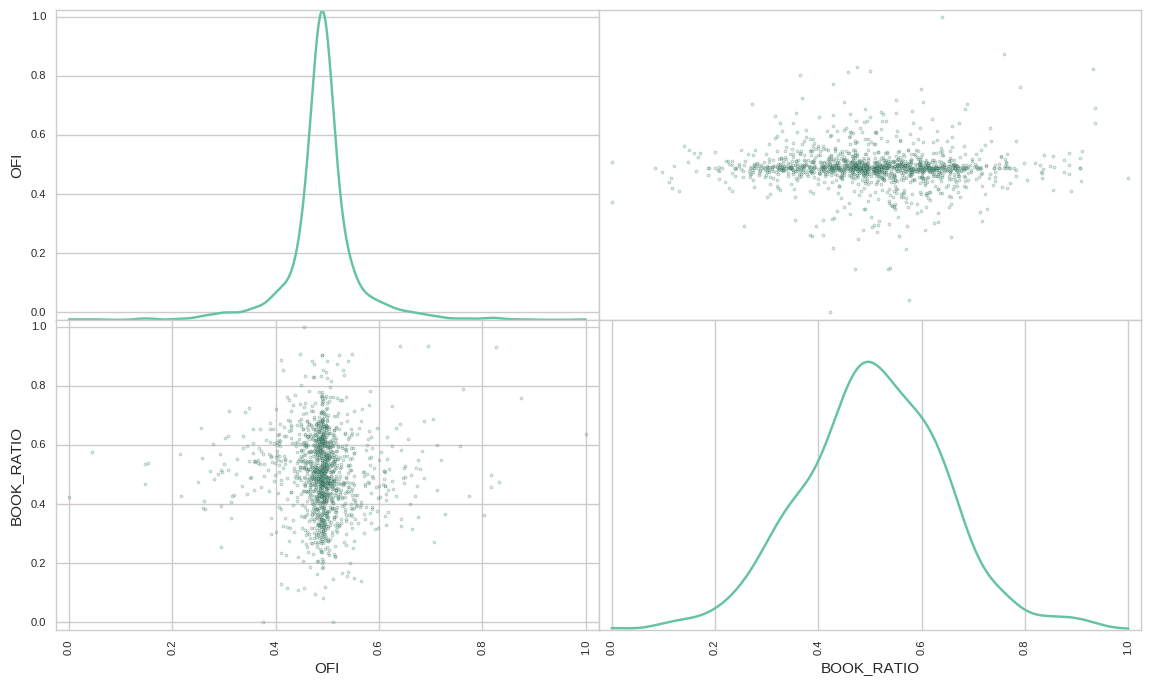

In [9]:
df_transformed = pd.DataFrame(d_transformed)
pd.scatter_matrix(df_transformed.ix[:, ['OFI', 'BOOK_RATIO']],
                    alpha = 0.3, figsize = (14,8), diagonal = 'kde');

As mentioned before, in an MDP environment the agent must visit every possible state-action pair infinitely often. If I just bucketize the variables and combine them, I will end up with a huge number of states to explore. So, to reduce the state space, I am going to group those variables using K-Means and Gaussian Mixture Model (GMM) clustering algorithm. Then I will quantify the "goodness" of the clustering results by calculating each data point's [silhouette coefficient](https://goo.gl/FUVD50). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). In the figure below, I am going to calculate the mean silhouette coefficient to K-Means and GMM using a different number of clusters. Also, I will test different covariance structures to GMM.

In [10]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
import time


reduced_data = df_transformed.ix[:, ['OFI', 'BOOK_RATIO']]
reduced_data.columns = ['Dimension 1', 'Dimension 2']
range_n_clusters = [2, 3, 4, 5, 6, 8, 10]

f_st = time.time()
d_score = {}
d_model = {}
s_key = "Kmeans"
d_score[s_key] = {}
d_model[s_key] = {}
for n_clusters in range_n_clusters:
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    preds = clusterer.fit_predict(reduced_data)
    d_model[s_key][n_clusters] = clusterer
    d_score[s_key][n_clusters] = metrics.silhouette_score(reduced_data, preds)
print "K-Means took {:0.2f} seconds to run over all complexity space".format(time.time() - f_st)

f_avg = 0

for covar_type in ['spherical', 'diag', 'tied', 'full']:
    f_st = time.time()
    s_key = "GMM_{}".format(covar_type)
    d_score[s_key] = {}
    d_model[s_key] = {}
    for n_clusters in range_n_clusters:
        
        # TODO: Apply your clustering algorithm of choice to the reduced data 
        clusterer = GMM(n_components=n_clusters,
                        covariance_type=covar_type,
                        random_state=10)
        clusterer.fit(reduced_data)
        preds = clusterer.predict(reduced_data)
        d_model[s_key][n_clusters] = clusterer
        d_score[s_key][n_clusters] = metrics.silhouette_score(reduced_data, preds)
        f_avg += time.time() - f_st
        
print "GMM took {:0.2f} seconds on average to run over all complexity space".format(f_avg / 4.)

K-Means took 4.59 seconds to run over all complexity space
GMM took 16.85 seconds on average to run over all complexity space


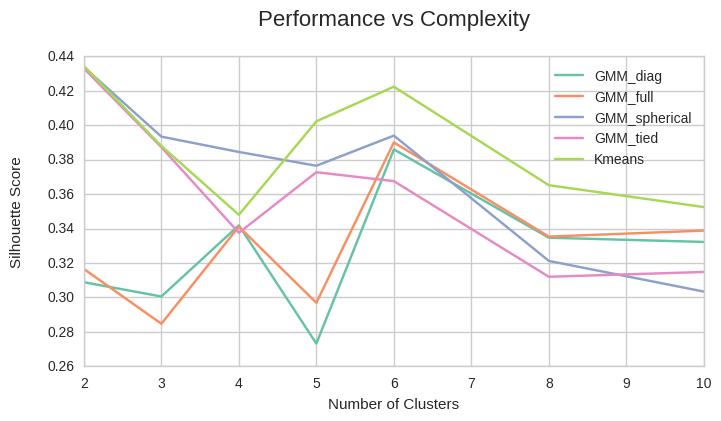

In [12]:
import pandas as pd
ax = pd.DataFrame(d_score).plot()
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score\n")
ax.set_title("Performance vs Complexity\n", fontsize = 16);


The maximum score has happened using 2 clusters.However, I believe that the market can't be simplified that much. So, I will use the K-means with six centroids to group the variables. In the figure below we can see how the algorithm classified the data. Also, in the following table, the centroid was put in their original scales.

In [13]:
# get centers
sample_preds = []
centers = d_model["Kmeans"][6].cluster_centers_
preds = d_model["Kmeans"][6].fit_predict(reduced_data)

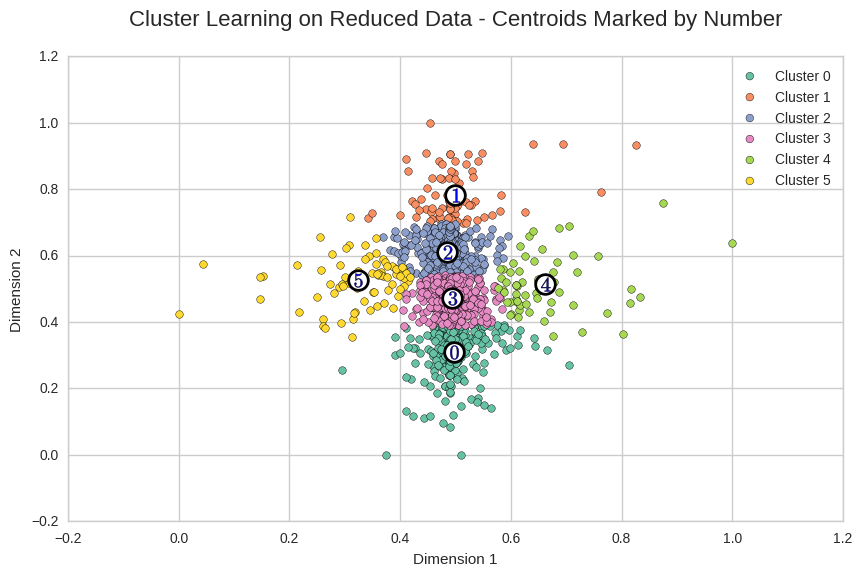

In [14]:
# Display the results of the clustering from implementation
import qtrader.eda as eda; reload(eda);
eda.cluster_results(reduced_data, preds, centers)

In [15]:
# recovering data
log_centers = centers.copy()
df_aux = pd.DataFrame([np.exp(scaler_bookratio.inverse_transform(log_centers.T[0].reshape(1, -1))[0]),
                      scaler_ofi.inverse_transform(log_centers.T[1].reshape(1, -1))[0]]).T
df_aux.columns = df_transformed.columns
df_aux.index.name = 'CLUSTER'
df_aux.columns = ['BOOK RATIO', 'OFI']
df_aux.round(2)

,BOOK RATIO,OFI
CLUSTER,,
0,0.89,-173662.94
1,0.91,281563.51
2,0.76,116727.32
3,0.85,-16602.29
4,7.91,23334.13
5,0.09,34240.00


Curiously, the algorithm gave more emphasis on the $BOOK\_RATIO$  when its value was very large (the bid size almost eight times greater than the ask size) or tiny (when the bid size was one tenth of the ask size). The other cluster seems mostly dominated by the $OFI$. In the next subsection, I will discuss how I have implemented the Q-learning, how I intend to perform the simulations and make some tests. *Lastly, let's serialize the objects used in clusterization to be used later. *

In [51]:
import pickle
pickle.dump(d_model["Kmeans"][6] ,open('data/kmeans_2.dat', 'w'))
pickle.dump(scaler_ofi, open('data/scale_ofi_2.dat', 'w'))
pickle.dump(scaler_bookratio, open('data/scale_bookratio_2.dat', 'w'))
print 'Done !'

Done !


### 3.2. Implementation

```
Udacity:

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?
- Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?
- Was there any part of the coding process (e.g., writing complicated functions) that should be documented?
```

As we have seen, learning the Q function corresponds to learning the optimal policy. According to \cite{Mohri_2012}, the optimal state-action value function $Q^{*}$ is defined for all $(s, \, a) \in S \times A$ as the expected return for taking the action $a \in A$ at the state $s \in S$, following the optimal policy. So, it can be written as \cite{Mitchell} suggested:

$$V^{*}(s) = \underset{a'}{\arg \max} \, Q(s, \, a')$$

Using this relationship, we can write a recursive definition of Q function, such that:

$$Q(s, \, a) = r(s, a) + \gamma \, \underset{a'}{\max} \, Q(\delta(s,\, a), \, a')$$

The recursive nature of the function above implies that our agent doesn't know the actual $Q$ function. It just can estimate $Q$, that we will refer as $\hat{Q}$. It will represents is hypothesis $\hat{Q}$ as a large table that attributes each pair $(s\, , \, a)$ to a value for $\hat{Q}(s,\, a)$ - the current hypothesis about the actual but unknown value $Q(s, \, a)$. I will initialize this table with zeros, but it could be filled with random numbers, according to \cite{Mitchell}. Still according to him, the agent repeatedly should observe its current state $s$ and do the following:



###### Algorithm 1: Update Q-table
- Observe the current state $s$ and the allowed actions $A^{*}$:
    - Choose some action $a \, \in \, A^{*}$ and execute it
    - Receive the immediate reward $r = r(s, a)$
    - if there is no entry $(s, \, a)$
        - initialize the table entry $\hat{Q}(s, \, a)$ to zero
    - Observe the new state $s' = \delta(s, \,a)$. 
    - Updates the table entry for $\hat{Q}(s, \, a)$ following:
        - $\hat{Q}(s, \, a) \leftarrow r + \gamma \underset{a'}{\max} \hat{Q}(s', \, a')$
- $s \leftarrow s'$

The main issue in the strategy presented in Algorithm 1 is that the agent could overcommit to actions that presented positive $\hat{Q}$ values early in the simulation, failing to explore other actions that could present even higher values. \cite{Mitchell} proposed to use a probabilistic approach to select actions, assigning higher probabilities to action with high $\hat{Q}$ values, but given to every action at least a nonzero probability. So, I will implement the following relation:

$$P(a_i\, | \,s ) = \frac{k ^{\hat{Q}(s, a_i)}}{\sum_j k^{\hat{Q}(s, a_j)}}$$

Where $P(a_i\, | \,s )$ is the probability of selecting the action $a_i$ given the state $s$. The constant $k$ is positive and determines how strongly the selection favors action with high $\hat{Q}$ values. Let's look at the number of times the algorithm choose to explore when we vary the value of the $k$.

Lastly, to optimize the policy, the agent will iterate over the same dataset repeately...
 
###### Algorithm 2: Train-Test Q-Learning Trader
- **for** each trial in total iterations desired **do**:
    - **for** each observation in the session **do**:
        - Update the table $\hat{Q}$
    - Save the table $\hat{Q}$ indexed by the trial ID
- **for** each trial in total iterations made **do**:
    - Load the table $\hat{Q}$ related to the current trial
    - **for** each observation in the session **do**:
        - Observe the current state $s$ and the allowed actions $A^{*}$:
            - **if** $s \, \notin  \, \hat{Q}$: Close out open positions or do nothing
            - **else**: Choose the optimal action $a \, \in \, A^{*}$ and execute it

Each learning session will include data from the largest part of a trading session, starting at 10:30 and closing at 16:30. Also, the agent will be allowed to hold a position of just 100 shares at maximum (buy or sell). When the learning session is over, all positions from the learner will be closed out so the agent always will start a new session without carrying stocks.

In [21]:
# analyze the logs from the in-sample tests
import qtrader.eda as eda;reload(eda);
s_fname = 'log/train_test/sim_Fri_Oct__7_002946_2016.log'  # 15 old
# s_fname = 'log/train_test/sim_Wed_Oct__5_110344_2016.log'  # 15
# s_fname = 'log/train_test/sim_Thu_Oct__6_165539_2016.log'  # 25
# s_fname = 'log/train_test/sim_Thu_Oct__6_175507_2016.log'  # 35
# s_fname = 'log/train_test/sim_Thu_Oct__6_183555_2016.log'  # 5
%time d_rtn_train_1 = eda.simple_counts(s_fname, 'LearningAgent_k')

CPU times: user 38.7 s, sys: 200 ms, total: 38.9 s
Wall time: 39.1 s


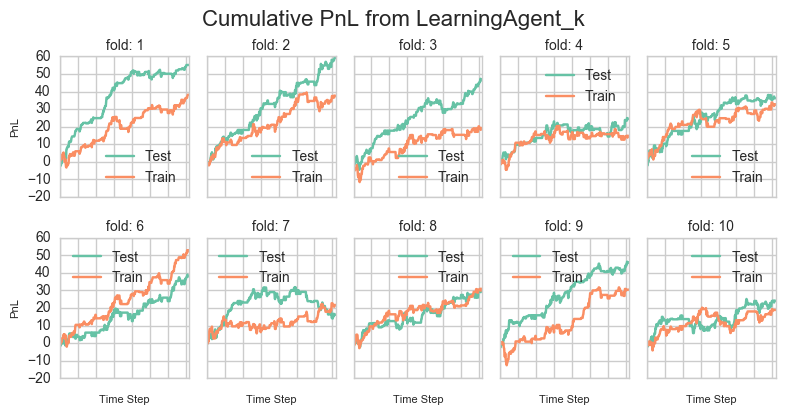

In [22]:
import qtrader.eda as eda; reload(eda);
eda.plot_train_test_sim(d_rtn_train_1)

In [23]:
# analyze the logs from the out-of-sample tests
import qtrader.eda as eda;reload(eda);
s_fname = 'log/train_test/sim_Fri_Oct__7_003943_2016.log'  # idx = 15 old
%time d_rtn_test_1 = eda.simple_counts(s_fname, 'LearningAgent_k')

CPU times: user 1.85 s, sys: 17.9 ms, total: 1.86 s
Wall time: 1.85 s


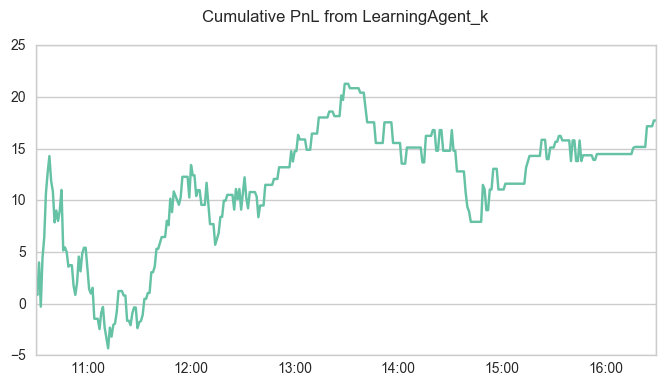

In [24]:
import pandas as pd
df_plot = pd.DataFrame(d_rtn_test_1['pnl']['test']).mean(axis=1).fillna(method='ffill')
ax1 = df_plot.plot(legend=False)
ax1.set_title('Cumulative PnL from LearningAgent_k\n');

In the next section, I will try different configurations of $k$ and $\gamma$ to try to improve the performance of the learning agent over the same trial.

### 3.3. Refinement
```
Udacity:

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- Has an initial solution been found and clearly reported?
- Is the process of improvement clearly documented, such as what techniques were used?
- Are intermediate and final solutions clearly reported as the process is improved?
```

In [156]:
# improving K
import qtrader.eda as eda;reload(eda);
s_fname = 'log/train_test/sim_Thu_Oct__6_133518_2016.log'
%time d_rtn3 = eda.count_by_k_gamma(s_fname, 'LearningAgent_k', 'k')

CPU times: user 41 s, sys: 108 ms, total: 41.1 s
Wall time: 41.7 s


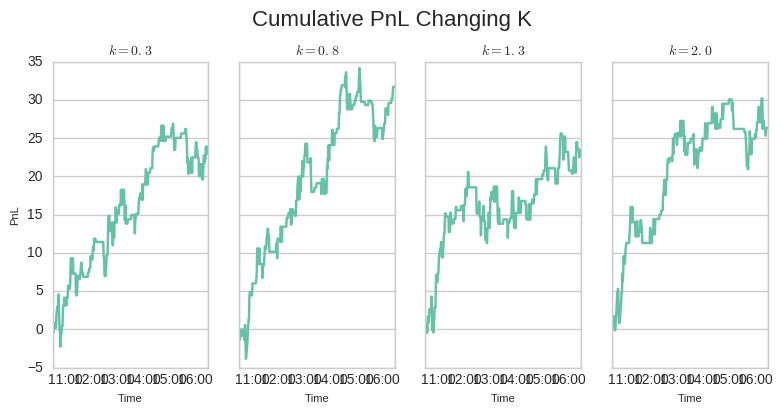

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

f, na_ax = plt.subplots(1, 4, sharex=True, sharey=True)
for ax1, s_key in zip(na_ax.ravel(), ['0.3', '0.8', '1.3', '2.0']):
    df_aux = pd.Series(d_rtn3[s_key][5])
    df_aux.plot(legend=False, ax=ax1)
    ax1.set_title('$k = {}$'.format(s_key), fontsize=10)
    ax1.xaxis.set_ticklabels([])
    ax1.set_ylabel('PnL', fontsize=8)
    ax1.set_xlabel('Time', fontsize=8)
f.tight_layout()
s_title = 'Cumulative PnL Changing K\n'
f.suptitle(s_title, fontsize=16, y=1.03);

In [164]:
# improving Gamma
import qtrader.eda as eda;reload(eda);
s_fname = 'log/train_test/sim_Thu_Oct__6_154516_2016.log'
%time d_rtn3 = eda.count_by_k_gamma(s_fname, 'LearningAgent_k', 'gamma')

CPU times: user 44.3 s, sys: 164 ms, total: 44.4 s
Wall time: 44.7 s


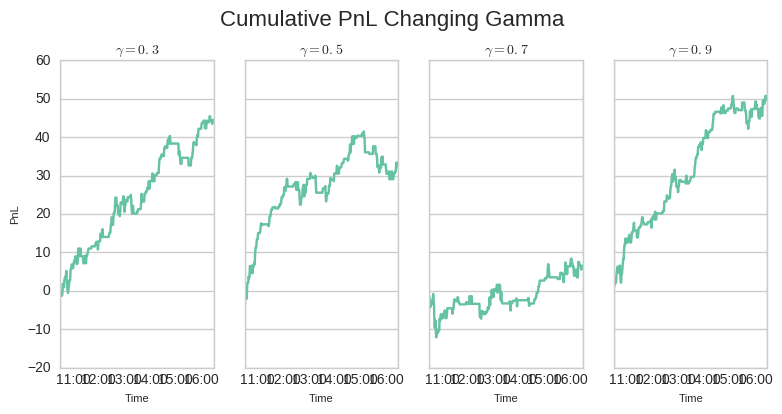

In [165]:
import pandas as pd
import matplotlib.pyplot as plt

f, na_ax = plt.subplots(1, 4, sharex=True, sharey=True)
for ax1, s_key in zip(na_ax.ravel(), ['0.3', '0.5', '0.7', '0.9']):
    df_aux = pd.Series(d_rtn3[s_key][5])
    df_aux.plot(legend=False, ax=ax1)
    ax1.set_title('$\gamma = {}$'.format(s_key), fontsize=10)
    ax1.xaxis.set_ticklabels([])
    ax1.set_ylabel('PnL', fontsize=8)
    ax1.set_xlabel('Time', fontsize=8)
f.tight_layout()
s_title = 'Cumulative PnL Changing Gamma\n'
f.suptitle(s_title, fontsize=16, y=1.03);

In [29]:
# analyze the logs from the in-sample tests
import qtrader.eda as eda;reload(eda);
# s_fname = 'log/train_test/sim_Fri_Oct__7_002946_2016.log'  # 15 old
s_fname = 'log/train_test/sim_Wed_Oct__5_110344_2016.log'  # 15
# s_fname = 'log/train_test/sim_Thu_Oct__6_165539_2016.log'  # 25
# s_fname = 'log/train_test/sim_Thu_Oct__6_175507_2016.log'  # 35
# s_fname = 'log/train_test/sim_Thu_Oct__6_183555_2016.log'  # 5
%time d_rtn_train_2 = eda.simple_counts(s_fname, 'LearningAgent_k')

CPU times: user 40.8 s, sys: 331 ms, total: 41.1 s
Wall time: 41.6 s


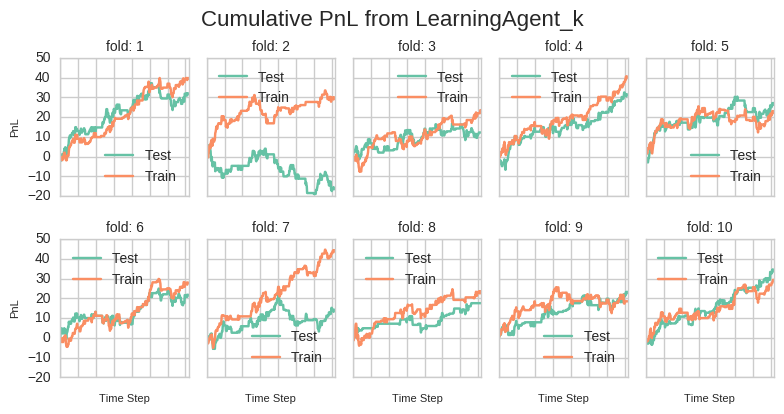

In [163]:
import qtrader.eda as eda; reload(eda);
eda.plot_train_test_sim(d_rtn)

In [25]:
# analyze the logs from the out-of-sample tests
import qtrader.eda as eda;reload(eda);
s_fname = 'log/train_test/sim_Wed_Oct__5_111812_2016.log'  # idx = 15
%time d_rtn_test_2 = eda.simple_counts(s_fname, 'LearningAgent_k')

CPU times: user 1.93 s, sys: 17.3 ms, total: 1.95 s
Wall time: 1.97 s


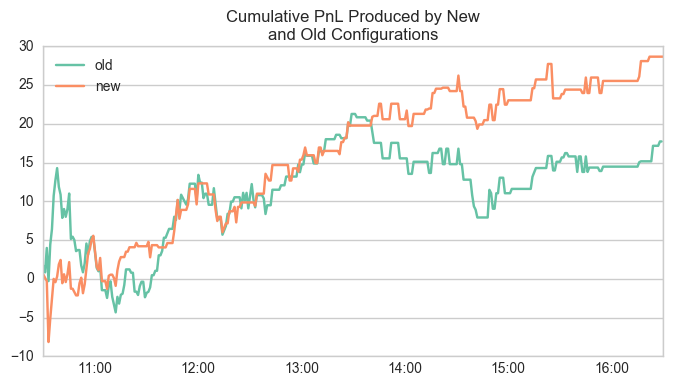

In [28]:
# compare the old with the data using the new configuration
import pandas as pd
df_plot = pd.DataFrame(d_rtn_test_1['pnl']['test']).mean(axis=1).fillna(method='ffill')
ax1 = df_plot.plot(legend=True, label='old')
df_plot = pd.DataFrame(d_rtn_test_2['pnl']['test']).mean(axis=1).fillna(method='ffill')
df_plot.plot(legend=True, label='new', ax=ax1)
ax1.set_title('Cumulative PnL Produced by New\nand Old Configurations');

## 4. Results
_(approx. 2-3 pages)_

### 4.1. Model Evaluation and Validation
```
Udacity:

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?
- Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?
- Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?
- Can results found from the model be trusted?
```

In [ ]:
# I should exclude the plot of the random at this point

In [33]:
# analyze the logs from the out-of-sample tests
import qtrader.eda as eda;reload(eda);
l_fname = ['log/train_test/sim_Thu_Oct__6_171842_2016.log',  # idx = 25
           'log/train_test/sim_Thu_Oct__6_181611_2016.log',  # idx = 35
           'log/train_test/sim_Thu_Oct__6_184852_2016.log']  # idx = 5
def foo(l_fname):
    d_learning_k = {}
    for idx, s_fname in zip([25, 35, 5], l_fname):
        d_learning_k[idx] = eda.simple_counts(s_fname, 'LearningAgent_k')
    return d_learning_k

%time d_learning_k = foo(l_fname)

CPU times: user 5.82 s, sys: 32.9 ms, total: 5.85 s
Wall time: 5.87 s


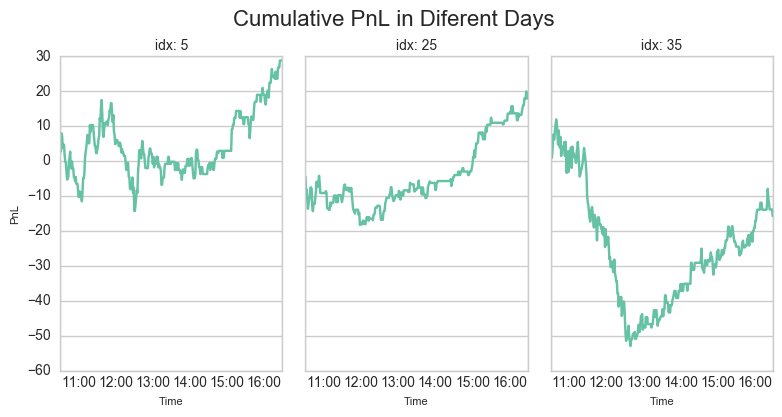

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

f, na_ax = plt.subplots(1, 3, sharey=True)
for ax1, idx in zip(na_ax.ravel(), [5, 25, 35]):
    df_plot = pd.DataFrame(d_learning_k[idx]['pnl']['test']).mean(axis=1)
    df_plot.fillna(method='ffill').plot(legend=False, ax=ax1)
    ax1.set_title('idx: {}'.format(idx), fontsize=10)
    ax1.set_ylabel('PnL', fontsize=8)
    ax1.set_xlabel('Time', fontsize=8)
f.tight_layout()
s_title = 'Cumulative PnL in Diferent Days\n'
f.suptitle(s_title, fontsize=16, y=1.03);

### 4.2. Justification
```
Udacity:

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- Are the final results found stronger than the benchmark result reported earlier?
- Have you thoroughly analyzed and discussed the final solution?
- Is the final solution significant enough to have solved the problem?
```


In [ ]:
# plot the same sharts, but include the random agent here

In [37]:
# analyze the logs from the out-of-sample random agent
import qtrader.eda as eda;reload(eda);
s_fname = 'log/train_test/sim_Wed_Oct__5_111907_2016.log'  # idx = 15
%time d_rtn_test_1r = eda.simple_counts(s_fname, 'BasicAgent')

CPU times: user 38.3 s, sys: 285 ms, total: 38.6 s
Wall time: 38.8 s


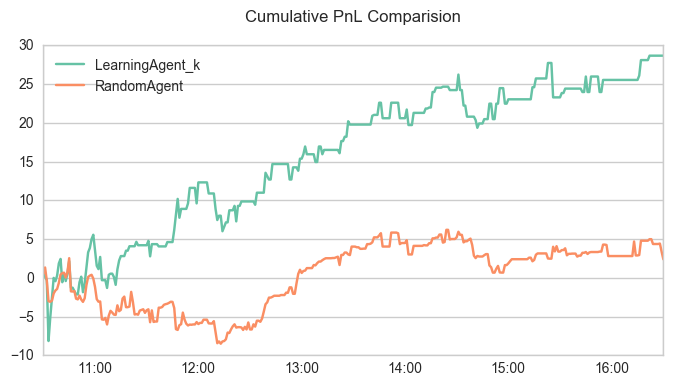

In [38]:
import pandas as pd
ax1 = pd.DataFrame(d_rtn_test_2['pnl']['test']).mean(axis=1).fillna(method='ffill').plot(legend=True, label='LearningAgent_k')
pd.DataFrame(d_rtn_test_1r['pnl']['test']).mean(axis=1).fillna(method='ffill').plot(legend=True, label='RandomAgent', ax=ax1)
ax1.set_title('Cumulative PnL Comparision\n');

In [36]:
# analyze the logs from the out-of-sample tests
import qtrader.eda as eda;reload(eda);
l_fname = ['log/train_test/sim_Thu_Oct__6_172024_2016.log',  # idx = 25
           'log/train_test/sim_Thu_Oct__6_181735_2016.log',  # idx = 35
           'log/train_test/sim_Thu_Oct__6_184957_2016.log']  # idx = 5
def foo(l_fname):
    d_basic = {}
    for idx, s_fname in zip([25, 35, 5], l_fname):
        d_basic[idx] = eda.simple_counts(s_fname, 'BasicAgent')
    return d_basic

%time d_basic = foo(l_fname)

CPU times: user 1min 59s, sys: 837 ms, total: 2min
Wall time: 2min 1s


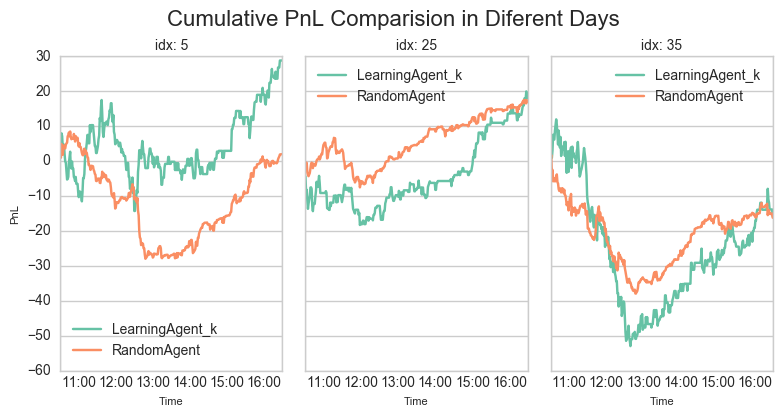

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

f, na_ax = plt.subplots(1, 3, sharey=True)
for ax1, idx in zip(na_ax.ravel(), [5, 25, 35]):
    df_plot = pd.DataFrame(d_learning_k[idx]['pnl']['test']).mean(axis=1)
    df_plot.fillna(method='ffill').plot(legend=True, label='LearningAgent_k', ax=ax1)
    df_plot = pd.DataFrame(d_basic[idx]['pnl']['test']).mean(axis=1)
    df_plot.fillna(method='ffill').plot(legend=True, label='RandomAgent', ax=ax1)
    ax1.set_title('idx: {}'.format(idx), fontsize=10)
    ax1.set_ylabel('PnL', fontsize=8)
    ax1.set_xlabel('Time', fontsize=8)
f.tight_layout()
s_title = 'Cumulative PnL Comparision in Diferent Days\n'
f.suptitle(s_title, fontsize=16, y=1.03);

## 5. Conclusion
_(approx. 1-2 pages)_

### 5.1. Free-Form Visualization
```
Udacity:

In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- Have you visualized a relevant or important quality about the problem, dataset, input data, or results?
- Is the visualization thoroughly analyzed and discussed?
- If a plot is provided, are the axes, title, and datum clearly defined?
```

In [15]:
# group all data in a single chart to acumulate the PnL

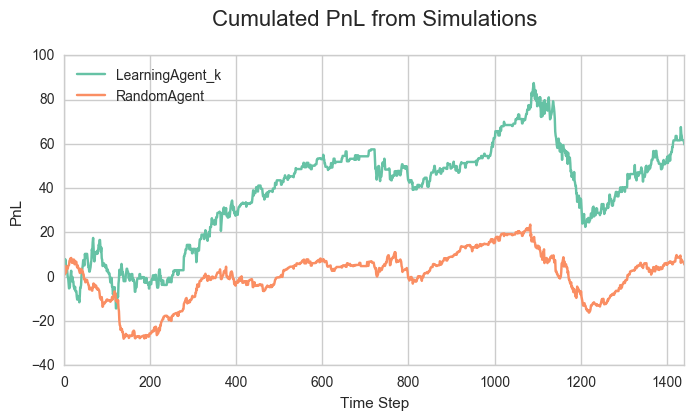

In [84]:
df_aux = pd.concat([pd.DataFrame(d_learning_k[5]['pnl']['test']),
                    pd.DataFrame(d_rtn_test_2['pnl']['test']),
                    pd.DataFrame(d_learning_k[25]['pnl']['test']),
                    pd.DataFrame(d_learning_k[35]['pnl']['test'])])
d_data = df_aux.to_dict()
df_plot = eda.make_df(d_data).reset_index(drop=True)[1]

df_aux = pd.concat([pd.DataFrame(d_basic[5]['pnl']['test']).mean(axis=1),
                    pd.DataFrame(d_rtn_test_1r['pnl']['test']).mean(axis=1),
                    pd.DataFrame(d_basic[25]['pnl']['test']).mean(axis=1),
                    pd.DataFrame(d_basic[35]['pnl']['test']).mean(axis=1)])
d_data = pd.DataFrame(df_aux).to_dict()
df_plot2 = eda.make_df(d_data).reset_index(drop=True)[0]


ax1 = df_plot.plot(legend=True, label='LearningAgent_k')
df_plot2.plot(legend=True, label='RandomAgent')
ax1.set_title('Cumulated PnL from Simulations\n', fontsize=16)
ax1.set_ylabel('PnL')
ax1.set_xlabel('Time Step');

### 5.2. Reflection
```
Udacity:

In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- Have you thoroughly summarized the entire process you used for this project?
- Were there any interesting aspects of the project?
- Were there any difficult aspects of the project?
- Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?
```

### 5.3. Improvement
```
Udacity:

In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- Are there further improvements that could be made on the algorithms or techniques you used in this project?
- Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?
- If you used your final solution as the new benchmark, do you think an even better solution exists?
```


*Style notebook and change matplotlib defaults*

In [87]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

IOError: [Errno 2] No such file or directory: ''

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))